In [1]:
import sys
sys.path.insert(0, '../src/')

import pickle
import warnings
warnings.filterwarnings('ignore')
import time


import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score, average_precision_score


#from netgan.netgan import *
#from netgan import utils

from net.utils import *
from net import utils_netgan as utils
import net.net as net

In [2]:
def grid_train(Model, train_graph, val_ones, val_zeros, Hs, EOs, mixing_coeff, 
               loss_fn, test_every=50, max_steps=2000):
    """Trains models with specified bottlenecks until specified edge overlaps are achieved and returns their
       graph statistics.
    
    Parameters
    ----------
    Model: net.Net class
               The model class used for training.
    train_graph: sparse matrix
               The train graph.
    val_ones: array
               Validation edges in train graph.
    val_zeros: array
               Validation non-edges in train graph.               
    Hs: list
               Bottlenecks, for which the model is trained.
    EOs: list
               Edge overlaps, for which the model is trained.
    mixing_coeff: float in [0,1]
               Controls contributions of stationary distribution and uniform distribution. 0 is uniform,
               1 is stationary.
    loss_fn: function
               Loss function for the model.
    test_every: integer
               Controls how often the edge overlap for stopping is tested during training.
    max_steps: integer
               Maximum number of training steps allowed to achieve the next edge overlap, starting from the
               model that achieves previous edge overlap.

    Returns
    -------
    dict_of_dicts_of_statistics: dictionary of dictionaries
                   Dictionary, for which value at key [i, j] is dictionary of graph statistics of the 
                   sampled graph with bottleneck Hs[i] and edge overlap EOs[j].

    """
    
    dict_of_dicts_of_statistics = {}
    E = train_graph.sum()
    actual_labels_val = np.append(np.ones(len(val_ones)), np.zeros(len(val_zeros)))
    
    counter = 0
    total = len(Hs) * len(EOs)
    for i, H in enumerate(Hs):
        # Define model with H 
        netmodel = Model(N=train_graph.shape[0],
                         H=H,
                         affine=False,
                         loss_fn=loss_fn,
                         stoppers=[net.OverlapStopper(train_graph=train_graph, 
                                                      mixing_coeff=mixing_coeff,
                                                      test_every=test_every)])
        train_time = 0
        for j, EO in enumerate(EOs):
            counter += 1
            print('Start training with H={H} and EO={EO} ({counter}/{total})'.format(H=H, EO=EO,
                                                                                     counter=counter,
                                                                                     total=total))
            start_time = time.time()

            # Train model until EO is reached, or a maximum of max_steps steps
            netmodel.train(generator=net_walker(walker),
                           steps=max_steps,
                           optimizer_fn=torch.optim.Adam,
                           optimizer_args={'lr': 0.01},
                           EO_criterion=EO)
            
            # Build graph
            transition_matrix = netmodel(torch.arange(start=0,end=_N, dtype=int))

            scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                                 symmetric=True,
                                                                 mixing_coeff=mixing_coeff)
            scores_matrix = sp.csr_matrix(scores_matrix)

            sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
            
            end_time = time.time()
            train_time += end_time - start_time
            # Compute graph statistics
            
            statistics = utils.compute_graph_statistics(sampled_graph)
            statistics['overlap'] = utils.edge_overlap(train_graph.toarray(), sampled_graph)/E
            edge_scores = np.append(scores_matrix[tuple(val_ones.T)].A1, 
                                    scores_matrix[tuple(val_zeros.T)].A1)
            statistics['val_performance'] = (roc_auc_score(actual_labels_val, edge_scores),
                                             average_precision_score(actual_labels_val, edge_scores))
            statistics['time'] = train_time
            
            # Test if EO is achieved
            if statistics['overlap']>EO:
                dict_of_dicts_of_statistics[i, j] = statistics
            else:
                counter += len(EOs) - j - 1
                print("Skipped remaining {} EOs".format(len(EOs) - j - 1))
                break
            
    return dict_of_dicts_of_statistics

def make_H_EO_grid_heatplot(dict_of_dicts_of_statistics, Hs, EOs, keys):
    """X.
    
    Parameters
    ----------
    X: X
        X       

    Returns
    -------
    X: X
        X

    """    
    n_rows, n_cols = get_plot_grid_size(len(keys))
    plt.rcParams.update({'font.size': 15})
    f, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axs = np.array(axs).reshape(n_rows, n_cols)
    plt.tight_layout(pad=3)
    for row in range(n_rows):
        for col in range(n_cols):
            i = row * n_cols + col
            if i < len(keys):
                key = keys[row * n_cols + col]
                vals = np.full((len(Hs), len(EOs)), np.nan)
                for index in np.ndindex(len(Hs), len(EOs)):
                    if index in dict_of_dicts_of_statistics.keys():
                        vals[index] = dict_of_dicts_of_statistics[index][key]
                axs[row, col].set_title(key)
                im = axs[row, col].imshow(vals.T[::-1]) # Make sure matrix is presented with right orientation
                axs[row, col].figure.colorbar(im, ax=axs[row, col])
                
                axs[row, col].set_xticks(np.arange(len(Hs)))
                axs[row, col].set_yticks(np.arange(len(EOs)))
                axs[row, col].set_xticklabels(Hs)
                axs[row, col].set_yticklabels(EOs[::-1])
                axs[row, col].set_xlabel('Bottleneck H')
                axs[row, col].set_ylabel('Edge overlap EO')                
            else:
                axs[row, col].axis('off')
    plt.savefig('hyperparameter_grid.pdf', format='pdf')
    return

## Test dependency of graph parameters on bottleneck H and edge overlap EO 

In [3]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

Selecting 1 largest connected components


In [4]:
rw_len = 16
batch_size = 128
mixing_coeff = 1
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

In [5]:
Hs = np.arange(1,101)
EOs = np.arange(0.05, 1, 0.05)

Hs = [20]
EOs = [0.3, 0.4]

dict_of_dicts_of_statistics = grid_train(Model=net.Net, train_graph=train_graph,
                                val_ones=val_ones, val_zeros=val_zeros,
                                Hs=Hs, EOs=EOs,
                                mixing_coeff=1,
                                loss_fn=torch.nn.functional.cross_entropy,
                                test_every=25,
                                max_steps=1500) 

Start training with H=20 and EO=0.3 (1/2)
Step: 24, Loss: 7.77624, Edge-Overlap: 0.002
Step: 49, Loss: 7.30462, Edge-Overlap: 0.003
Step: 74, Loss: 6.26861, Edge-Overlap: 0.019
Step: 99, Loss: 5.11525, Edge-Overlap: 0.115
Step: 124, Loss: 4.14560, Edge-Overlap: 0.226
Step: 149, Loss: 3.67699, Edge-Overlap: 0.320
Start training with H=20 and EO=0.4 (2/2)
Step: 149, Loss: 3.69503, Edge-Overlap: 0.323
Step: 174, Loss: 3.44125, Edge-Overlap: 0.355
Step: 199, Loss: 3.17696, Edge-Overlap: 0.418


In [6]:
pickle.dump( dict_of_dicts_of_statistics, open( "dict.p", "wb" ) )
pickle.dump( Hs, open( "Hs.p", "wb" ) )
pickle.dump( EOs, open( "EOs.p", "wb" ) )

In [7]:
# dict_of_dicts_of_statistics = pickle.load( open( "dict.p", "rb" ) )
# Hs = pickle.load( open( "Hs.p", "rb" ) )
# EOs = pickle.load( open( "EOs.p", "rb" ) )

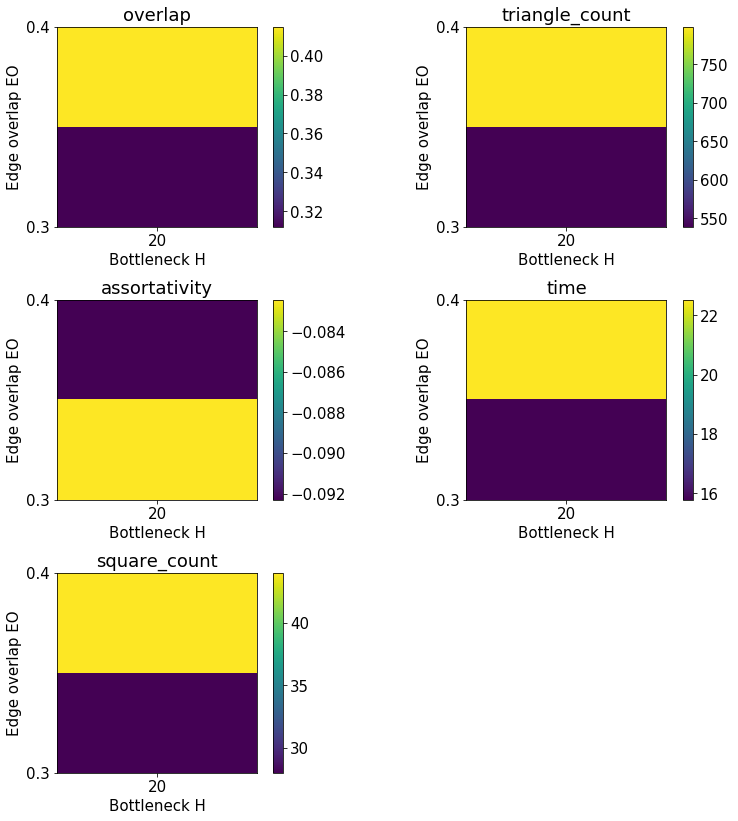

In [8]:
make_H_EO_grid_heatplot(dict_of_dicts_of_statistics=dict_of_dicts_of_statistics, Hs=Hs, EOs=EOs, keys=['overlap', 
                                                                                     'triangle_count', 
                                                                                     'assortativity',
                                                                                     'time',
                                                                                     'square_count'])